# `Lateral_Movement_Threat_Detection_only_provenance`

# Attack Graph Analytics on Containers Research on Lateral Movement Threat Detection in Kubernetes Environment

## Preliminaries

### Imports

In [1]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import re

### Define Args

In [2]:
# Path to Provenance Data
prov_data_path = 'provenance_data/prov_JSON/prov-worker-0912231.json'
# Path to Attack Graph Directory
ag_dir_path = 'AG'
# Path to Kubernetes Service Data
kubectl_svc = 'kubectl_svc.json'
# Path to Attack Graph Arcs File
arcs_file = f'{ag_dir_path}/ARCS.csv'
# Path to Attack Graph Vertices File
vertices_file = f'{ag_dir_path}/VERTICES.csv'
# Path to Alert Data
alert_data_path = 'alerts_mechanism/lateral_movement_example_alerts.csv'

## Provenance Data Loading

In [3]:
# Load Provenance Data
with open(prov_data_path, 'r') as json_file:
    prov_data = json.load(json_file)

In [4]:
# Show Sample Data
prov_data[0]

{'annotations': {'gid': '1000',
  'euid': '1000',
  'children pid namespace': '-1',
  'pid': '4728',
  'seen time': '1702119793.080',
  'source': 'syscall',
  'net namespace': '-1',
  'ipc namespace': '-1',
  'ppid': '4186',
  'pid namespace': '-1',
  'cwd': '/data',
  'uid': '1000',
  'egid': '1000',
  'exe': '/usr/local/bin/redis-server',
  'mount namespace': '-1',
  'name': 'redis-server',
  'user namespace': '-1'},
 'id': 'bf568478eb1e54952760f72d50144a4e',
 'type': 'Process'}

## Preprocess Provenance Data

### Prepare Edges and Vertices

In [5]:
# Separate edges and vertices data

edges_data = []
vertices_process = []
vertices_artifacts = []

for item in prov_data:
    if 'type' in item:
        # Separate vertices to dataframes according to their type - 'Process' or 'Artifact'
        if item['type'] == 'Process':
            vertices_process.append(item)
        elif item['type'] == 'Artifact':
            vertices_artifacts.append(item)
        else:
            edges_data.append(item)

In [6]:
# Get all unique types of edges
edge_types = set()
for item in edges_data:
    edge_types.add(item['type'])
print(edge_types)

# No AGENT vertices

{'WasTriggeredBy', 'Used', 'WasGeneratedBy'}


In [7]:
# Count number of edges and vertices unfiltered
print(f"number of edges: {len(edges_data)}")
print(f"number of vertices: {len(vertices_process) + len(vertices_artifacts)}")
print(f"number of processes: {len(vertices_process)}")
print(f"number of artifacts: {len(vertices_artifacts)}")

number of edges: 39087
number of vertices: 3405
number of processes: 643
number of artifacts: 2762


In [8]:
# Load process vertices data into a pandas dataframe
process_df = pd.DataFrame(vertices_process)

# Convert the dictionary in annotations column into columns in process_df
annotations_process_df = pd.DataFrame(process_df['annotations'].tolist())

# Combine annotations_process_df with process_df instead of the 'annotations' column in process_df
process_df = pd.concat([process_df, annotations_process_df], axis=1).drop('annotations', axis=1)
process_df

id     type   gid  euid  \
0    bf568478eb1e54952760f72d50144a4e  Process  1000  1000   
1    9db76e1f086a76a9e8dd1548f05d2fa8  Process  1000  1000   
2    46dea032f4342cafd765deaee9067628  Process   116   112   
3    413b8704b3209061ce63aaa13a274964  Process  1000  1000   
4    0ef366a12c22d68dcc35e410ab69719e  Process  1000  1000   
..                                ...      ...   ...   ...   
638  09f4ab5b14d6f9f2af1ad6fcda6c7623  Process  1000  1000   
639  c31db7322a8b70395140d140667700d6  Process  1000  1000   
640  5ebe4fceb72860e7470d44db5eaa655a  Process  1000  1000   
641  29569b52a8ab611e1dfc28ccb0ecb21a  Process  1000  1000   
642  7f23d8b3b74310b68c740fc957ee8312  Process   106   102   

    children pid namespace    pid       seen time   source net namespace  \
0                       -1   4728  1702119793.080  syscall            -1   
1                       -1  30850  1702119793.148  syscall            -1   
2                       -1   1142  1702119793.508  syscall            -1   
3                       -1   1711  1702119793.592  syscall            -1   
4                       -1   1711             NaN  syscall            -1   
..                     ...    ...             ...      ...           ...   
638             4026532690   3666             NaN  syscall    4026532382   
639             4026532690   3667             NaN  syscall    4026532382   
640             4026532690   3668             NaN  syscall    4026532382   
641             4026532690   3669             NaN  syscall    4026532382   
642                     -1   1067  1702119826.452  syscall            -1   

    ipc namespace  ...            cwd   uid  egid  \
0              -1  ...          /data  1000  1000   
1              -1  ...              /  1000  1000   
2              -1  ...            NaN   112   116   
3              -1  ...            NaN  1000  1000   
4              -1  ...  /email_server  1000  1000   
..            ...  ...            ...   ...   ...   
638    4026532669  ...   /usr/src/app  1000  1000   
639    4026532669  ...   /usr/src/app  1000  1000   
640    4026532669  ...   /usr/src/app  1000  1000   
641    4026532669  ...   /usr/src/app  1000  1000   
642            -1  ...              /   102   106   

                             exe mount namespace             name  \
0    /usr/local/bin/redis-server              -1     redis-server   
1           /lib/systemd/systemd              -1          systemd   
2                            NaN              -1          chronyd   
3                              /              -1    runc:[2:INIT]   
4         /bin/grpc_health_probe              -1  grpc_health_pro   
..                           ...             ...              ...   
638       /bin/grpc_health_probe      4026532689  grpc_health_pro   
639       /bin/grpc_health_probe      4026532689  grpc_health_pro   
640       /bin/grpc_health_probe      4026532689  grpc_health_pro   
641       /bin/grpc_health_probe      4026532689  grpc_health_pro   
642           /usr/sbin/rsyslogd              -1    rs:main Q:Reg   

    user namespace      start time                         command line ns pid  
0               -1             NaN                                  NaN    NaN  
1               -1             NaN                                  NaN    NaN  
2               -1             NaN                                  NaN    NaN  
3               -1             NaN                                  NaN    NaN  
4               -1  1702119793.592   /bin/grpc_health_probe -addr=:8080    NaN  
..             ...             ...                                  ...    ...  
638     4026531837  1702119825.720  /bin/grpc_health_probe -addr=:50051   1376  
639     4026531837  1702119825.724  /bin/grpc_health_probe -addr=:50051   1377  
640     4026531837  1702119825.728  /bin/grpc_health_probe -addr=:50051   1378  
641     4026531837  1702119825.728  /bin/grpc_health_probe -addr=:50051   1379  
642             -1  

In [9]:
# Load artifact vertices data into a pandas dataframe
artifact_df=pd.DataFrame(vertices_artifacts)

# Convert the dictionary in annotations column into columns in artifact_df
annotations_artifact_df = pd.DataFrame(artifact_df['annotations'].tolist())

# Combine annotations_artifact_df with artifact_df instead of the 'annotations' column in artifact_df
artifact_df = pd.concat([artifact_df, annotations_artifact_df], axis=1).drop('annotations', axis=1)
artifact_df

id      type                   path  \
0     81338e410c018f63993f6e06c077c34e  Artifact        /proc/4728/stat   
1     521d86a2612ed5d128b9cae6350c4ea6  Artifact  /proc/30850/mountinfo   
2     7b65297e7853d3c2609c9699289a1337  Artifact        /run/mount/utab   
3     2940488a0e3c1b3238183afaeb05a262  Artifact                      /   
4     88cd5a7ee47fdc85dea662449c90e238  Artifact                   /sys   
...                                ...       ...                    ...   
2757  3590db22532593fa2136e450a85658f3  Artifact                    NaN   
2758  c2d9426e2cdd5a172638ac72381b1048  Artifact                    NaN   
2759  58fec781896a518ed3adf046ed9e8548  Artifact                    NaN   
2760  cd9b49dcd834bd4771719cbffbf5370e  Artifact                    NaN   
2761  0ef5f6d816adb32da9ff11dcecab0e52  Artifact          /var/run/utmp   

             subtype permissions epoch   source version  \
0               file        0444     0  syscall       0   
1               file        0444     0  syscall       0   
2               file        0644     0  syscall       0   
3          directory        0755     0  syscall       0   
4          directory        0555     0  syscall       0   
...              ...         ...   ...      ...     ...   
2757          memory         NaN   NaN  syscall       0   
2758          memory         NaN   NaN  syscall       0   
2759  network socket         NaN     0  syscall       0   
2760  network socket         NaN     0  syscall       0   
2761            file        0664     0  syscall       0   

                                local address remote port protocol  \
0                                         NaN         NaN      NaN   
1                                         NaN         NaN      NaN   
2                                         NaN         NaN      NaN   
3                                         NaN         NaN      NaN   
4                                         NaN         NaN      NaN   
...                                       ...         ...      ...   
2757                                      NaN         NaN      NaN   
2758                                      NaN         NaN      NaN   
2759                                127.0.0.1       50051      tcp   
2760  0000:0000:0000:0000:0000:0000:0000:0000       37622      tcp   
2761                                      NaN         NaN      NaN   

                               remote address local port net namespace  \
0                                         NaN        NaN           NaN   
1                                         NaN        NaN           NaN   
2                                         NaN        NaN           NaN   
3                                         NaN        NaN           NaN   
4                                         NaN        NaN           NaN   
...                                       ...        ...           ...   
2757                                      NaN        NaN           NaN   
2758                                      NaN        NaN           NaN   
2759                                  0.0.0.0      37622    4026532382   
2760  0000:0000:0000:0000:0000:FFFF:7F00:0001      50051            -1   
2761                                      NaN        NaN           NaN   

     memory address   size  tgid read fd write fd  
0               NaN    NaN   NaN     NaN      NaN  
1               NaN    NaN   NaN     NaN      NaN  
2               NaN    NaN   NaN     NaN      NaN  
3               NaN    NaN   NaN     NaN      NaN  
4               NaN    NaN   NaN     NaN      NaN  
...             ...    ...   ...     ...      ...  
2757   7fe433ed9000  40000  3657     NaN      NaN  
2758   7fe433e99000  40000  3657     NaN      NaN  
2759            NaN    NaN   NaN     NaN      NaN  
2760            NaN    NaN   NaN     NaN      NaN  
2761            NaN    NaN   NaN     NaN      NaN  

[2762 rows x 19 columns]

### Add Kubernetes Service Data

In [10]:
# Load kubectl_svc.json file
with open(kubectl_svc, 'r') as json_file:
    svc_data = json.load(json_file)

# Create a dataframe consisting of services names and ports from kubectl_svc.json file
svc_df = pd.DataFrame(columns=['service_name', 'port'])
for item in svc_data['items']:
    svc_name = item['metadata']['name']
    for p in item['spec']['ports']:
        # port_name = item['spec']['ports'][0]['name']
        port_num = item['spec']['ports'][0]['port']
        # Add all of the above variables to the dataframe using pd.concat
        # svc_df = pd.concat([svc_df, pd.DataFrame([[svc_name, port_name, port_num]], columns=['service_name', 'port_name', 'port'])])
        svc_df = pd.concat([svc_df, pd.DataFrame([[svc_name, port_num]], columns=['service_name', 'port'])], ignore_index=True)

svc_df

service_name   port
0               adservice   9555
1             cartservice   7070
2         checkoutservice   5050
3         currencyservice   7000
4            emailservice   5000
5                frontend     80
6       frontend-external     80
7              kubernetes    443
8          paymentservice  50051
9   productcatalogservice   3550
10  recommendationservice   8080
11             redis-cart   6379
12        shippingservice  50051

In [11]:
# Extract all values from 'svc_df' columns and convert them to a set for efficient lookup
svc_values = set()
for column in svc_df.columns:
    svc_values.update(svc_df[column].astype(str))

# Remove the substring "service" from values in svc_values and add it as another item instead
svc_values = set([value.replace('service', '') for value in svc_values])
svc_values.add('service')

svc_values

{'3550',
 '443',
 '5000',
 '50051',
 '5050',
 '6379',
 '7000',
 '7070',
 '80',
 '8080',
 '9555',
 'ad',
 'cart',
 'checkout',
 'currency',
 'email',
 'frontend',
 'frontend-external',
 'kubernetes',
 'payment',
 'productcatalog',
 'recommendation',
 'redis-cart',
 'service',
 'shipping'}

In [12]:
# Helper function for boolean mask to filter rows according to svc_values
def contains_substring(value, svc_values):
    for svc_value in svc_values:
        if svc_value in value:
            return True
    return False

In [13]:
# Create a boolean mask to filter 'process_df' rows, only by the following columns: 'exe', 'name', 'cwd', 'command line'
proc_filter_cols = ['exe', 'name', 'cwd', 'command line']
svc_proc_mask = process_df[proc_filter_cols].apply(lambda row: any(contains_substring(value, svc_values) for value in row.astype(str)), axis=1)

# Use the mask to create a new DataFrame with matching rows
app_process_df = process_df[svc_proc_mask].copy()  # Make a copy to avoid the warning

app_process_df

id     type   gid  euid  \
4    0ef366a12c22d68dcc35e410ab69719e  Process  1000  1000   
5    3f921fd1ce1cc790417d2071cc0a3c34  Process  1000  1000   
6    e6103611b0969dad371a1d6e665772e7  Process  1000  1000   
7    ff8a80868c60e4a5a1503a31124cd340  Process  1000  1000   
9    b6acb3e5c8618efc89e85cd9e2ee9823  Process  1000  1000   
..                                ...      ...   ...   ...   
637  124d026d2a64c4b2c67947a310bb3e68  Process  1000  1000   
638  09f4ab5b14d6f9f2af1ad6fcda6c7623  Process  1000  1000   
639  c31db7322a8b70395140d140667700d6  Process  1000  1000   
640  5ebe4fceb72860e7470d44db5eaa655a  Process  1000  1000   
641  29569b52a8ab611e1dfc28ccb0ecb21a  Process  1000  1000   

    children pid namespace   pid seen time   source net namespace  \
4                       -1  1711       NaN  syscall            -1   
5               4026532688  1723       NaN  syscall    4026532231   
6               4026532688  1724       NaN  syscall    4026532231   
7               4026532688  1725       NaN  syscall    4026532231   
9               4026532688  1726       NaN  syscall    4026532231   
..                     ...   ...       ...      ...           ...   
637             4026532690  3665       NaN  syscall    4026532382   
638             4026532690  3666       NaN  syscall    4026532382   
639             4026532690  3667       NaN  syscall    4026532382   
640             4026532690  3668       NaN  syscall    4026532382   
641             4026532690  3669       NaN  syscall    4026532382   

    ipc namespace  ...            cwd   uid  egid                     exe  \
4              -1  ...  /email_server  1000  1000  /bin/grpc_health_probe   
5      4026532657  ...  /email_server  1000  1000  /bin/grpc_health_probe   
6      4026532657  ...  /email_server  1000  1000  /bin/grpc_health_probe   
7      4026532657  ...  /email_server  1000  1000  /bin/grpc_health_probe   
9      4026532657  ...  /email_server  1000  1000  /bin/grpc_health_probe   
..            ...  ...            ...   ...   ...                     ...   
637    4026532669  ...   /usr/src/app  1000  1000  /bin/grpc_health_probe   
638    4026532669  ...   /usr/src/app  1000  1000  /bin/grpc_health_probe   
639    4026532669  ...   /usr/src/app  1000  1000  /bin/grpc_health_probe   
640    4026532669  ...   /usr/src/app  1000  1000  /bin/grpc_health_probe   
641    4026532669  ...   /usr/src/app  1000  1000  /bin/grpc_health_probe   

    mount namespace             name user namespace      start time  \
4                -1  grpc_health_pro             -1  1702119793.592   
5        4026532687  grpc_health_pro     4026531837  1702119793.596   
6        4026532687  grpc_health_pro     4026531837  1702119793.596   
7        4026532687  grpc_health_pro     4026531837  1702119793.596   
9        4026532687  grpc_health_pro     4026531837  1702119793.604   
..              ...              ...            ...             ...   
637      4026532689  grpc_health_pro     4026531837  1702119825.720   
638      4026532689  grpc_health_pro     4026531837  1702119825.720   
639      4026532689  grpc_health_pro     4026531837  1702119825.724   
640      4026532689  grpc_health_pro     4026531837  1702119825.728   
641      4026532689  grpc_health_pro     4026531837  1702119825.728   

                            command line ns pid  
4     /bin/grpc_health_probe -addr=:8080    NaN  
5     /bin/grpc_health_probe -addr=:8080   2489  
6     /bin/grpc_health_probe -addr=:8080   2490  
7     /bin/grpc_health_probe -addr=:8080   2491  
9     /bin/grpc_health_probe -addr=:8080   2492  
..                                   ...    ...  
637  /bin/grpc_health_probe -addr=:50051   1375  
638  /bin/grpc_health_probe -addr=:50051   1376  
639  /bin/grpc_health_probe -addr=:50051   1377  
640  /bin/grpc_health_probe -addr=:50051   1378  
641  /bin/grpc_health_probe -addr=:50051   1379  

[501 rows x 22 columns]

In [14]:
# Create a function to get the service_name for a given row
def get_service_name(row, svc_values, svc_df):
    for value in row.astype(str):
        if any(svc_value in value for svc_value in svc_values):
            # Get the service_name from svc_df based on the matched value
            for index, row in svc_df.iterrows():
                if any(svc_value in value for svc_value in row.astype(str)):
                    return row['service_name']
    return ".No app/k8s service found"

In [15]:
# Apply the function to add a new 'svc' column to app_process_df
app_process_df['svc'] = app_process_df[proc_filter_cols].apply(lambda row: get_service_name(row, svc_values, svc_df), axis=1)

# Now, 'app_process_df' contains the 'svc' column with the associated service_name
app_process_df

id     type   gid  euid  \
4    0ef366a12c22d68dcc35e410ab69719e  Process  1000  1000   
5    3f921fd1ce1cc790417d2071cc0a3c34  Process  1000  1000   
6    e6103611b0969dad371a1d6e665772e7  Process  1000  1000   
7    ff8a80868c60e4a5a1503a31124cd340  Process  1000  1000   
9    b6acb3e5c8618efc89e85cd9e2ee9823  Process  1000  1000   
..                                ...      ...   ...   ...   
637  124d026d2a64c4b2c67947a310bb3e68  Process  1000  1000   
638  09f4ab5b14d6f9f2af1ad6fcda6c7623  Process  1000  1000   
639  c31db7322a8b70395140d140667700d6  Process  1000  1000   
640  5ebe4fceb72860e7470d44db5eaa655a  Process  1000  1000   
641  29569b52a8ab611e1dfc28ccb0ecb21a  Process  1000  1000   

    children pid namespace   pid seen time   source net namespace  \
4                       -1  1711       NaN  syscall            -1   
5               4026532688  1723       NaN  syscall    4026532231   
6               4026532688  1724       NaN  syscall    4026532231   
7               4026532688  1725       NaN  syscall    4026532231   
9               4026532688  1726       NaN  syscall    4026532231   
..                     ...   ...       ...      ...           ...   
637             4026532690  3665       NaN  syscall    4026532382   
638             4026532690  3666       NaN  syscall    4026532382   
639             4026532690  3667       NaN  syscall    4026532382   
640             4026532690  3668       NaN  syscall    4026532382   
641             4026532690  3669       NaN  syscall    4026532382   

    ipc namespace  ...   uid  egid                     exe mount namespace  \
4              -1  ...  1000  1000  /bin/grpc_health_probe              -1   
5      4026532657  ...  1000  1000  /bin/grpc_health_probe      4026532687   
6      4026532657  ...  1000  1000  /bin/grpc_health_probe      4026532687   
7      4026532657  ...  1000  1000  /bin/grpc_health_probe      4026532687   
9      4026532657  ...  1000  1000  /bin/grpc_health_probe      4026532687   
..            ...  ...   ...   ...                     ...             ...   
637    4026532669  ...  1000  1000  /bin/grpc_health_probe      4026532689   
638    4026532669  ...  1000  1000  /bin/grpc_health_probe      4026532689   
639    4026532669  ...  1000  1000  /bin/grpc_health_probe      4026532689   
640    4026532669  ...  1000  1000  /bin/grpc_health_probe      4026532689   
641    4026532669  ...  1000  1000  /bin/grpc_health_probe      4026532689   

                name user namespace      start time  \
4    grpc_health_pro             -1  1702119793.592   
5    grpc_health_pro     4026531837  1702119793.596   
6    grpc_health_pro     4026531837  1702119793.596   
7    grpc_health_pro     4026531837  1702119793.596   
9    grpc_health_pro     4026531837  1702119793.604   
..               ...            ...             ...   
637  grpc_health_pro     4026531837  1702119825.720   
638  grpc_health_pro     4026531837  1702119825.720   
639  grpc_health_pro     4026531837  1702119825.724   
640  grpc_health_pro     4026531837  1702119825.728   
641  grpc_health_pro     4026531837  1702119825.728   

                            command line ns pid             svc  
4     /bin/grpc_health_probe -addr=:8080    NaN        frontend  
5     /bin/grpc_health_probe -addr=:8080   2489        frontend  
6     /bin/grpc_health_probe -addr=:8080   2490        frontend  
7     /bin/grpc_health_probe -addr=:8080   2491        frontend  
9     /bin/grpc_health_probe -addr=:8080   2492        frontend  
..                                   ...    ...             ...  
637  /bin/grpc_health_probe -addr=:50051   1375  paymentservice  
638  /bin/grpc_health_probe -addr=:50051   1376  paymentservice  
639  /bin/grpc_health_probe -addr=:50051   1377  paymentservice  
640  /bin/grpc_health_probe -addr=:50051   1378  paymentservice  
641  /bin/grpc_health_probe -addr=:50051   1379  paymentservice  

[501 rows x 23 columns]

In [16]:
# Count unique values in svc column in app_process_df
app_process_df['svc'].value_counts()

paymentservice               105
recommendationservice         90
frontend                      88
cartservice                   54
currencyservice               52
checkoutservice               41
productcatalogservice         37
adservice                     26
.No app/k8s service found      5
shippingservice                3
Name: svc, dtype: int64

In [17]:
# Create new dataframe without the rows with the value '.No app/k8s service found' in the 'svc' column in app_process_df
app_process_df = app_process_df[app_process_df['svc'] != '.No app/k8s service found']
app_process_df.columns

Index(['id', 'type', 'gid', 'euid', 'children pid namespace', 'pid',
       'seen time', 'source', 'net namespace', 'ipc namespace', 'ppid',
       'pid namespace', 'cwd', 'uid', 'egid', 'exe', 'mount namespace', 'name',
       'user namespace', 'start time', 'command line', 'ns pid', 'svc'],
      dtype='object')

In [18]:
# Create a boolean mask to filter 'artifact_df' rows
art_filter_cols = ['path', 'local address', 'remote port', 'protocol', 'remote address', 'local port']
svc_art_mask = artifact_df[art_filter_cols].apply(lambda row: any(contains_substring(value, svc_values) for value in row.astype(str)), axis=1)

# Use the mask to create a new DataFrame with matching rows
app_artifact_df = artifact_df[svc_art_mask].copy()  # Make a copy to avoid the warning

app_artifact_df

id      type path         subtype  \
48    a41db92088a31a823a23ed48145dd661  Artifact  NaN  network socket   
49    a2f50c6b069415c603efdac935d00de4  Artifact  NaN  network socket   
96    be892937315bea0644510e695d37ac30  Artifact  NaN  network socket   
97    5a7a49b0a1c2096d4e6e896d35f9194d  Artifact  NaN  network socket   
98    80a3b6046c1aa2dda29b76dc32d1e4fa  Artifact  NaN  network socket   
...                                ...       ...  ...             ...   
2708  3998eceda38b8f5dae8cc3bae8bf54e0  Artifact  NaN  network socket   
2732  21b987534f7bbaa103be947ab2d950ad  Artifact  NaN  network socket   
2733  5238236d70966fe2bda3eb36fbe49df9  Artifact  NaN  network socket   
2759  58fec781896a518ed3adf046ed9e8548  Artifact  NaN  network socket   
2760  cd9b49dcd834bd4771719cbffbf5370e  Artifact  NaN  network socket   

     permissions epoch   source version  \
48           NaN     0  syscall       0   
49           NaN     0  syscall       0   
96           NaN     0  syscall       0   
97           NaN     0  syscall       0   
98           NaN     0  syscall       0   
...          ...   ...      ...     ...   
2708         NaN     0  syscall       0   
2732         NaN     0  syscall       0   
2733         NaN     0  syscall       0   
2759         NaN     0  syscall       0   
2760         NaN     0  syscall       0   

                                local address remote port protocol  \
48                                    0.0.0.0       39612      tcp   
49                                    0.0.0.0       39614      tcp   
96                                  127.0.0.1        8080      tcp   
97    0000:0000:0000:0000:0000:0000:0000:0000       46636      tcp   
98                                  127.0.0.1        8080      tcp   
...                                       ...         ...      ...   
2708                                127.0.0.1        7000      tcp   
2732  0000:0000:0000:0000:0000:0000:0000:0000       43390      tcp   
2733                                127.0.0.1        3550      tcp   
2759                                127.0.0.1       50051      tcp   
2760  0000:0000:0000:0000:0000:0000:0000:0000       37622      tcp   

                               remote address local port net namespace  \
48                              172.31.30.227       6379            -1   
49                              172.31.30.227       6379            -1   
96                                    0.0.0.0      46636    4026532231   
97    0000:0000:0000:0000:0000:FFFF:7F00:0001       8080            -1   
98                                    0.0.0.0      46642    4026532231   
...                                       ...        ...           ...   
2708                                  0.0.0.0      35042    4026532583   
2732  0000:0000:0000:0000:0000:FFFF:7F00:0001       3550            -1   
2733                                  0.0.0.0      43390            -1   
2759                                  0.0.0.0      37622    4026532382   
2760  0000:0000:0000:0000:0000:FFFF:7F00:0001      50051            -1   

     memory address size tgid read fd write fd  
48              NaN  NaN  NaN     NaN      NaN  
49              NaN  NaN  NaN     NaN      NaN  
96              NaN  NaN  NaN     NaN      NaN  
97              NaN  NaN  NaN     NaN      NaN  
98              NaN  NaN  NaN     NaN      NaN  
...             ...  ...  ...     ...      ...  
2708            NaN  NaN  NaN     NaN      NaN  
2732            NaN  NaN  NaN     NaN      NaN  
2733            NaN  NaN  NaN     NaN      NaN  
2759            NaN  NaN  NaN     NaN      NaN  
2760            NaN  NaN  NaN     NaN      NaN  

[168 rows x 19 columns]

In [19]:
# Apply the function to add a new 'svc' column to app_artifact_df
app_artifact_df['svc'] = app_artifact_df[art_filter_cols].apply(lambda row: get_service_name(row, svc_values, svc_df), axis=1)
app_artifact_df

id      type path         subtype  \
48    a41db92088a31a823a23ed48145dd661  Artifact  NaN  network socket   
49    a2f50c6b069415c603efdac935d00de4  Artifact  NaN  network socket   
96    be892937315bea0644510e695d37ac30  Artifact  NaN  network socket   
97    5a7a49b0a1c2096d4e6e896d35f9194d  Artifact  NaN  network socket   
98    80a3b6046c1aa2dda29b76dc32d1e4fa  Artifact  NaN  network socket   
...                                ...       ...  ...             ...   
2708  3998eceda38b8f5dae8cc3bae8bf54e0  Artifact  NaN  network socket   
2732  21b987534f7bbaa103be947ab2d950ad  Artifact  NaN  network socket   
2733  5238236d70966fe2bda3eb36fbe49df9  Artifact  NaN  network socket   
2759  58fec781896a518ed3adf046ed9e8548  Artifact  NaN  network socket   
2760  cd9b49dcd834bd4771719cbffbf5370e  Artifact  NaN  network socket   

     permissions epoch   source version  \
48           NaN     0  syscall       0   
49           NaN     0  syscall       0   
96           NaN     0  syscall       0   
97           NaN     0  syscall       0   
98           NaN     0  syscall       0   
...          ...   ...      ...     ...   
2708         NaN     0  syscall       0   
2732         NaN     0  syscall       0   
2733         NaN     0  syscall       0   
2759         NaN     0  syscall       0   
2760         NaN     0  syscall       0   

                                local address remote port protocol  \
48                                    0.0.0.0       39612      tcp   
49                                    0.0.0.0       39614      tcp   
96                                  127.0.0.1        8080      tcp   
97    0000:0000:0000:0000:0000:0000:0000:0000       46636      tcp   
98                                  127.0.0.1        8080      tcp   
...                                       ...         ...      ...   
2708                                127.0.0.1        7000      tcp   
2732  0000:0000:0000:0000:0000:0000:0000:0000       43390      tcp   
2733                                127.0.0.1        3550      tcp   
2759                                127.0.0.1       50051      tcp   
2760  0000:0000:0000:0000:0000:0000:0000:0000       37622      tcp   

                               remote address local port net namespace  \
48                              172.31.30.227       6379            -1   
49                              172.31.30.227       6379            -1   
96                                    0.0.0.0      46636    4026532231   
97    0000:0000:0000:0000:0000:FFFF:7F00:0001       8080            -1   
98                                    0.0.0.0      46642    4026532231   
...                                       ...        ...           ...   
2708                                  0.0.0.0      35042    4026532583   
2732  0000:0000:0000:0000:0000:FFFF:7F00:0001       3550            -1   
2733                                  0.0.0.0      43390            -1   
2759                                  0.0.0.0      37622    4026532382   
2760  0000:0000:0000:0000:0000:FFFF:7F00:0001      50051            -1   

     memory address size tgid read fd write fd                    svc  
48              NaN  NaN  NaN     NaN      NaN             redis-cart  
49              NaN  NaN  NaN     NaN      NaN             redis-cart  
96              NaN  NaN  NaN     NaN      NaN               frontend  
97              NaN  NaN  NaN     NaN      NaN               frontend  
98              NaN  NaN  NaN     NaN      NaN               frontend  
...             ...  ...  ...     ...      ...                    ...  
2708            NaN  NaN  NaN     NaN      NaN        currencyservice  
2732            NaN  NaN  NaN     NaN      NaN  productcatalogservice  
2733            NaN  NaN  NaN     NaN      NaN  productcatalogservice  
2759            NaN  NaN  NaN     NaN      NaN         paymentservice  
2760            NaN  NaN  NaN     NaN      NaN         paymentservice  

[168 rows x 20 columns]

In [20]:
# Add to app_artifact_df rows from artifact_df that contain values in 'tgid' column that are also in app_process_df 'pid' column
tgid_app_artifact_df = pd.concat([app_artifact_df, artifact_df[artifact_df['tgid'].isin(app_process_df['pid'])]])

tgid_app_artifact_df

id      type path         subtype  \
48    a41db92088a31a823a23ed48145dd661  Artifact  NaN  network socket   
49    a2f50c6b069415c603efdac935d00de4  Artifact  NaN  network socket   
96    be892937315bea0644510e695d37ac30  Artifact  NaN  network socket   
97    5a7a49b0a1c2096d4e6e896d35f9194d  Artifact  NaN  network socket   
98    80a3b6046c1aa2dda29b76dc32d1e4fa  Artifact  NaN  network socket   
...                                ...       ...  ...             ...   
2754  e42c94e07eeb67b22db5bfe04871a556  Artifact  NaN          memory   
2755  b73dc1bfd3dbf8baf9df86abb1edd701  Artifact  NaN          memory   
2756  e632a6b0731ba7453465352ffa5fcf15  Artifact  NaN          memory   
2757  3590db22532593fa2136e450a85658f3  Artifact  NaN          memory   
2758  c2d9426e2cdd5a172638ac72381b1048  Artifact  NaN          memory   

     permissions epoch   source version  \
48           NaN     0  syscall       0   
49           NaN     0  syscall       0   
96           NaN     0  syscall       0   
97           NaN     0  syscall       0   
98           NaN     0  syscall       0   
...          ...   ...      ...     ...   
2754         NaN   NaN  syscall       0   
2755         NaN   NaN  syscall       0   
2756         NaN   NaN  syscall       0   
2757         NaN   NaN  syscall       0   
2758         NaN   NaN  syscall       0   

                                local address remote port protocol  \
48                                    0.0.0.0       39612      tcp   
49                                    0.0.0.0       39614      tcp   
96                                  127.0.0.1        8080      tcp   
97    0000:0000:0000:0000:0000:0000:0000:0000       46636      tcp   
98                                  127.0.0.1        8080      tcp   
...                                       ...         ...      ...   
2754                                      NaN         NaN      NaN   
2755                                      NaN         NaN      NaN   
2756                                      NaN         NaN      NaN   
2757                                      NaN         NaN      NaN   
2758                                      NaN         NaN      NaN   

                               remote address local port net namespace  \
48                              172.31.30.227       6379            -1   
49                              172.31.30.227       6379            -1   
96                                    0.0.0.0      46636    4026532231   
97    0000:0000:0000:0000:0000:FFFF:7F00:0001       8080            -1   
98                                    0.0.0.0      46642    4026532231   
...                                       ...        ...           ...   
2754                                      NaN        NaN           NaN   
2755                                      NaN        NaN           NaN   
2756                                      NaN        NaN           NaN   
2757                                      NaN        NaN           NaN   
2758                                      NaN        NaN           NaN   

     memory address   size  tgid read fd write fd         svc  
48              NaN    NaN   NaN     NaN      NaN  redis-cart  
49              NaN    NaN   NaN     NaN      NaN  redis-cart  
96              NaN    NaN   NaN     NaN      NaN    frontend  
97              NaN    NaN   NaN     NaN      NaN    frontend  
98              NaN    NaN   NaN     NaN      NaN    frontend  
...             ...    ...   ...     ...      ...         ...  
2754   7fe433f69000  10000  3657     NaN      NaN         NaN  
2755   7fe433f59000  10000  3657     NaN      NaN         NaN  
2756   7fe433f19000  40000  3657     NaN      NaN         NaN  
2757   7fe433ed9000  40000  3657     NaN      NaN         NaN  
2758   7fe433e99000  40000  3657     NaN      NaN         NaN  

[1578 rows x 20 columns]

In [21]:
# Create a dictionary to map 'pid' values to 'svc' values in app_process_df
pid_to_svc_dict = app_process_df.set_index('pid')['svc'].to_dict()

# Add to the svc column of the new rows added the value from the svc column of the corresponding row in app_process_df
tgid_app_artifact_df['svc'] = tgid_app_artifact_df['svc'].fillna(tgid_app_artifact_df['tgid'].map(pid_to_svc_dict))

tgid_app_artifact_df

id      type path         subtype  \
48    a41db92088a31a823a23ed48145dd661  Artifact  NaN  network socket   
49    a2f50c6b069415c603efdac935d00de4  Artifact  NaN  network socket   
96    be892937315bea0644510e695d37ac30  Artifact  NaN  network socket   
97    5a7a49b0a1c2096d4e6e896d35f9194d  Artifact  NaN  network socket   
98    80a3b6046c1aa2dda29b76dc32d1e4fa  Artifact  NaN  network socket   
...                                ...       ...  ...             ...   
2754  e42c94e07eeb67b22db5bfe04871a556  Artifact  NaN          memory   
2755  b73dc1bfd3dbf8baf9df86abb1edd701  Artifact  NaN          memory   
2756  e632a6b0731ba7453465352ffa5fcf15  Artifact  NaN          memory   
2757  3590db22532593fa2136e450a85658f3  Artifact  NaN          memory   
2758  c2d9426e2cdd5a172638ac72381b1048  Artifact  NaN          memory   

     permissions epoch   source version  \
48           NaN     0  syscall       0   
49           NaN     0  syscall       0   
96           NaN     0  syscall       0   
97           NaN     0  syscall       0   
98           NaN     0  syscall       0   
...          ...   ...      ...     ...   
2754         NaN   NaN  syscall       0   
2755         NaN   NaN  syscall       0   
2756         NaN   NaN  syscall       0   
2757         NaN   NaN  syscall       0   
2758         NaN   NaN  syscall       0   

                                local address remote port protocol  \
48                                    0.0.0.0       39612      tcp   
49                                    0.0.0.0       39614      tcp   
96                                  127.0.0.1        8080      tcp   
97    0000:0000:0000:0000:0000:0000:0000:0000       46636      tcp   
98                                  127.0.0.1        8080      tcp   
...                                       ...         ...      ...   
2754                                      NaN         NaN      NaN   
2755                                      NaN         NaN      NaN   
2756                                      NaN         NaN      NaN   
2757                                      NaN         NaN      NaN   
2758                                      NaN         NaN      NaN   

                               remote address local port net namespace  \
48                              172.31.30.227       6379            -1   
49                              172.31.30.227       6379            -1   
96                                    0.0.0.0      46636    4026532231   
97    0000:0000:0000:0000:0000:FFFF:7F00:0001       8080            -1   
98                                    0.0.0.0      46642    4026532231   
...                                       ...        ...           ...   
2754                                      NaN        NaN           NaN   
2755                                      NaN        NaN           NaN   
2756                                      NaN        NaN           NaN   
2757                                      NaN        NaN           NaN   
2758                                      NaN        NaN           NaN   

     memory address   size  tgid read fd write fd             svc  
48              NaN    NaN   NaN     NaN      NaN      redis-cart  
49              NaN    NaN   NaN     NaN      NaN      redis-cart  
96              NaN    NaN   NaN     NaN      NaN        frontend  
97              NaN    NaN   NaN     NaN      NaN        frontend  
98              NaN    NaN   NaN     NaN      NaN        frontend  
...             ...    ...   ...     ...      ...             ...  
2754   7fe433f69000  10000  3657     NaN      NaN  paymentservice  
2755   7fe433f59000  10000  3657     NaN      NaN  paymentservice  
2756   7fe433f19000  40000  3657     NaN      NaN  paymentservice  
2757   7fe433ed9000  40000  3657     NaN      NaN  paymentservice  
2758   7fe433e99000  40000  3657     NaN      NaN  paymentservice  

[1578 rows x 20 columns]

In [22]:
# Check if there are null values in svc column in app_artifact_df
tgid_app_artifact_df['svc'].isnull().values.any()
# Return the rows with null values in svc column in app_artifact_df
tgid_app_artifact_df[tgid_app_artifact_df['svc'].isnull()]

Empty DataFrame
Columns: [id, type, path, subtype, permissions, epoch, source, version, local address, remote port, protocol, remote address, local port, net namespace, memory address, size, tgid, read fd, write fd, svc]
Index: []

In [23]:
# Count unique values in svc column in app_artifact_df
tgid_app_artifact_df['svc'].value_counts()

paymentservice           338
frontend                 328
recommendationservice    253
currencyservice          160
cartservice              159
productcatalogservice    121
checkoutservice          115
adservice                 90
redis-cart                14
Name: svc, dtype: int64

In [24]:
# Print sizes of dataframes
print(f"number of app related processes: {len(app_process_df)}")
print(f"number of app related artifacts + tgid: {len(tgid_app_artifact_df)}")

number of app related processes: 496
number of app related artifacts + tgid: 1578


In [25]:
# Create edges dataframe from edges_data
edges_df = pd.DataFrame(edges_data)

In [26]:
# Convert the dictionary in annotations column into columns in edges_df
annotations_edges_df = pd.DataFrame(edges_df['annotations'].tolist())

# Combine annotations_edges_df with edges_df instead of the 'annotations' column in edges_df
edges_df = pd.concat([edges_df, annotations_edges_df], axis=1).drop('annotations', axis=1)
edges_df

from                                to  \
0      bf568478eb1e54952760f72d50144a4e  81338e410c018f63993f6e06c077c34e   
1      bf568478eb1e54952760f72d50144a4e  81338e410c018f63993f6e06c077c34e   
2      9db76e1f086a76a9e8dd1548f05d2fa8  521d86a2612ed5d128b9cae6350c4ea6   
3      9db76e1f086a76a9e8dd1548f05d2fa8  521d86a2612ed5d128b9cae6350c4ea6   
4      9db76e1f086a76a9e8dd1548f05d2fa8  7b65297e7853d3c2609c9699289a1337   
...                                 ...                               ...   
39082  bf568478eb1e54952760f72d50144a4e  81338e410c018f63993f6e06c077c34e   
39083  bf568478eb1e54952760f72d50144a4e  81338e410c018f63993f6e06c077c34e   
39084  bf568478eb1e54952760f72d50144a4e  81338e410c018f63993f6e06c077c34e   
39085  7f23d8b3b74310b68c740fc957ee8312  0ef5f6d816adb32da9ff11dcecab0e52   
39086  7f23d8b3b74310b68c740fc957ee8312  0ef5f6d816adb32da9ff11dcecab0e52   

       type event id     flags   source            time operation protection  \
0      Used      342  O_RDONLY  syscall  1702119793.080      open        NaN   
1      Used      343       NaN  syscall  1702119793.080     close        NaN   
2      Used      345  O_RDONLY  syscall  1702119793.148      open        NaN   
3      Used      346       NaN  syscall  1702119793.148     close        NaN   
4      Used      347  O_RDONLY  syscall  1702119793.148      open        NaN   
...     ...      ...       ...      ...             ...       ...        ...   
39082  Used    56784       NaN  syscall  1702119826.316     close        NaN   
39083  Used    56785  O_RDONLY  syscall  1702119826.416      open        NaN   
39084  Used    56786       NaN  syscall  1702119826.416     close        NaN   
39085  Used    56793  O_RDONLY  syscall  1702119826.452      open        NaN   
39086  Used    56806       NaN  syscall  1702119826.452     close        NaN   

      advice  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
39082    NaN  
39083    NaN  
39084    NaN  
39085    NaN  
39086    NaN  

[39087 rows x 10 columns]

In [27]:
# Create sets of unique IDs from app_process_df and app_artifact_df
app_process_ids = set(app_process_df['id'])
app_artifact_ids = set(tgid_app_artifact_df['id'])

# Filter edges_df based on whether 'from' or 'to' vertices are in the sets of IDs
app_edges_df = edges_df[edges_df['from'].isin(app_process_ids) | edges_df['to'].isin(app_process_df) | edges_df['from'].isin(app_artifact_ids) | edges_df['to'].isin(app_artifact_ids)]

# Now, app_edges_df contains only the edges with vertices in app_process_df or app_artifact_df
app_artifact_df=tgid_app_artifact_df
app_edges_df

from                                to  \
458    bf568478eb1e54952760f72d50144a4e  a41db92088a31a823a23ed48145dd661   
459    bf568478eb1e54952760f72d50144a4e  a2f50c6b069415c603efdac935d00de4   
460    a41db92088a31a823a23ed48145dd661  bf568478eb1e54952760f72d50144a4e   
461    a2f50c6b069415c603efdac935d00de4  bf568478eb1e54952760f72d50144a4e   
915    0ef366a12c22d68dcc35e410ab69719e  413b8704b3209061ce63aaa13a274964   
...                                 ...                               ...   
39053  29569b52a8ab611e1dfc28ccb0ecb21a  4b0a0f495e2585697f7da7b211a2ef60   
39054  58fec781896a518ed3adf046ed9e8548  c31db7322a8b70395140d140667700d6   
39055  9cf27ca975bc259abdaf366fb69ab287  cd9b49dcd834bd4771719cbffbf5370e   
39058  4b0a0f495e2585697f7da7b211a2ef60  4b0a0f495e2585697f7da7b211a2ef60   
39060  cd9b49dcd834bd4771719cbffbf5370e  9cf27ca975bc259abdaf366fb69ab287   

                 type event id  \
458              Used      841   
459              Used      842   
460    WasGeneratedBy      843   
461    WasGeneratedBy      846   
915    WasTriggeredBy     1307   
...               ...      ...   
39053  WasTriggeredBy    56570   
39054  WasGeneratedBy    56571   
39055            Used    56572   
39058  WasTriggeredBy    56575   
39060  WasGeneratedBy    56577   

                                                   flags   source  \
458                                                  NaN  syscall   
459                                                  NaN  syscall   
460                                                  NaN  syscall   
461                                                  NaN  syscall   
915                                                  NaN  syscall   
...                                                  ...      ...   
39053  CLONE_SIGHAND|CLONE_SETTLS|CLONE_SYSVSEM|CLONE...  syscall   
39054                                                NaN  syscall   
39055                                                NaN  syscall   
39058                                                NaN  syscall   
39060                                                NaN  syscall   

                 time operation protection advice  
458    1702119793.532    accept        NaN    NaN  
459    1702119793.532    accept        NaN    NaN  
460    1702119793.532     close        NaN    NaN  
461    1702119793.532     close        NaN    NaN  
915    1702119793.592    execve        NaN    NaN  
...               ...       ...        ...    ...  
39053  1702119825.728     clone        NaN    NaN  
39054  1702119825.728   connect        NaN    NaN  
39055  1702119825.728    accept        NaN    NaN  
39058  1702119825.732      exit        NaN    NaN  
39060  1702119825.736     close        NaN    NaN  

[2550 rows x 10 columns]

## Final Provenance Data

In [28]:
app_process_df.to_csv('app_process.csv')
app_artifact_df.to_csv('app_artifact.csv')
app_edges_df.to_csv('app_edges.csv')

number of edges: 2550
number of vertices: 2074
number of processes: 496
number of artifacts: 1578


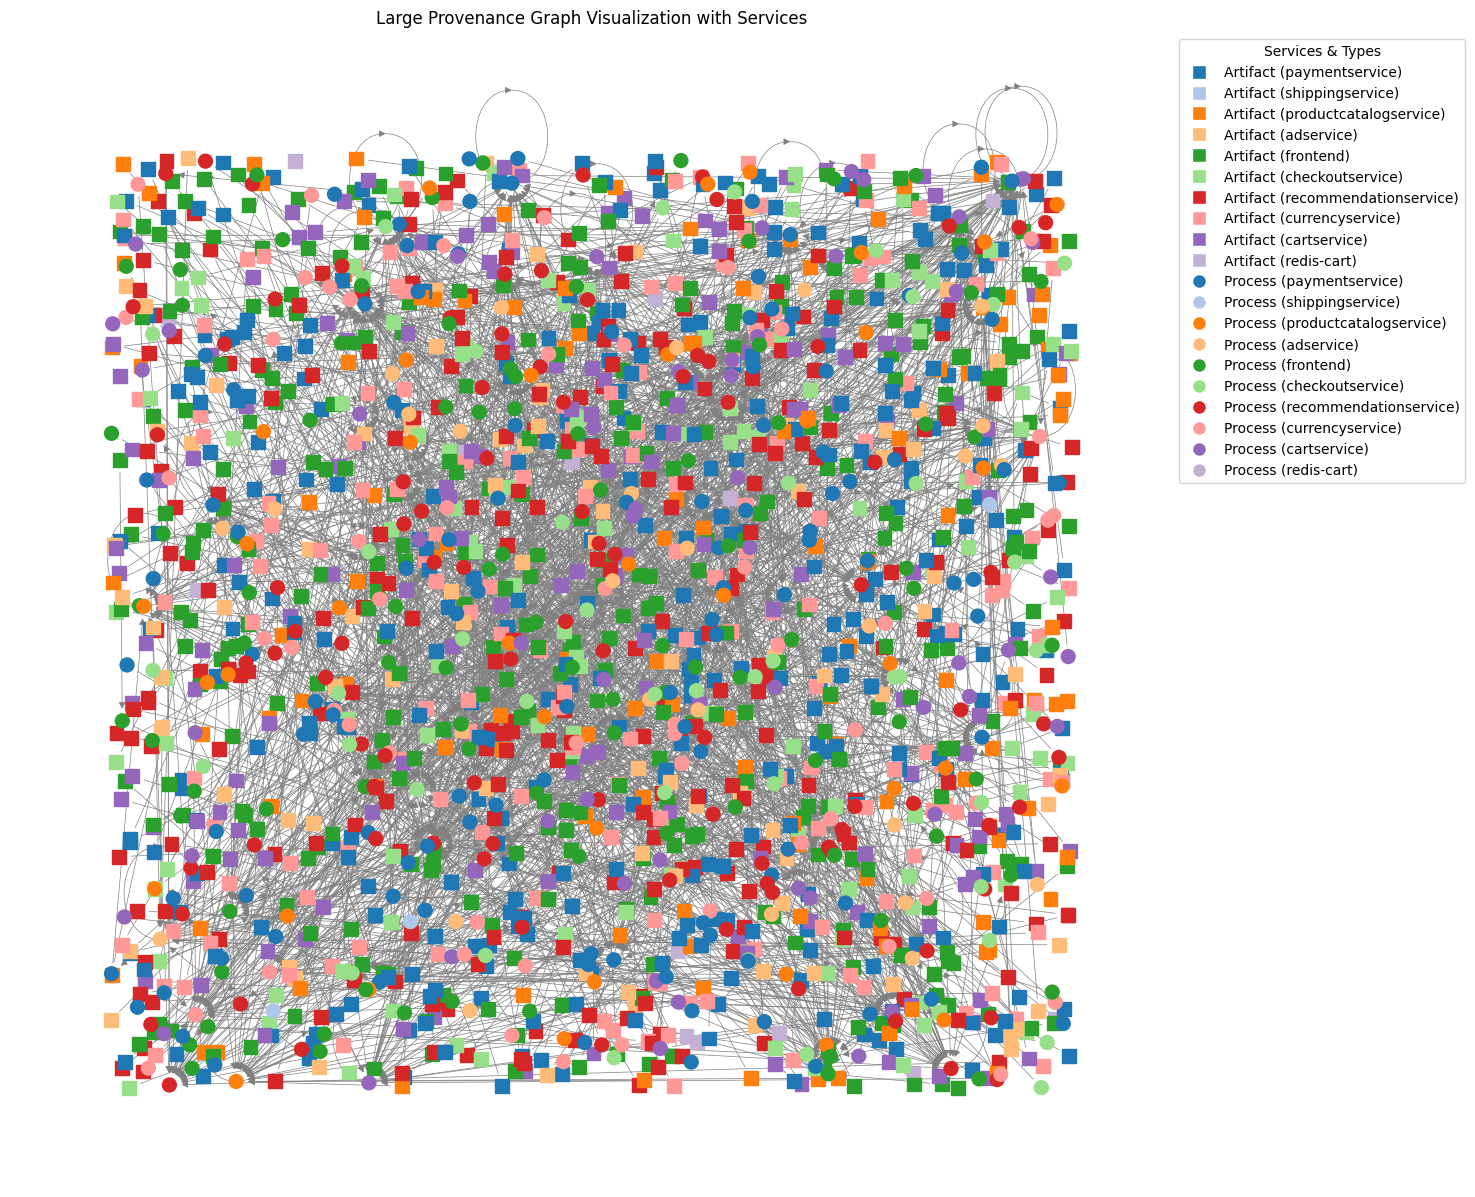

In [217]:
def create_large_provenance_graph_with_services(artifacts_df, processes_df, edges_df, name='prov_graph_full'):
    # Create a directed graph
    G = nx.DiGraph()

    # Assuming 'service' is the column that indicates the service for each artifact and process
    service_column = 'svc'  # Replace with your actual column name

    # Generate a color palette for services
    services = set(artifacts_df[service_column]).union(set(processes_df[service_column]))
    color_palette = plt.get_cmap('tab20')(range(len(services)))
    service_colors = dict(zip(services, color_palette))

    # Add nodes for artifacts and processes
    for _, row in artifacts_df.iterrows():
        G.add_node(row['id'], type='Artifact', color=service_colors[row[service_column]])

    for _, row in processes_df.iterrows():
        G.add_node(row['id'], type='Process', color=service_colors[row[service_column]])

    # Add edges without specific colors
    for _, row in edges_df.iterrows():
        if row['from'] in G and row['to'] in G:
            G.add_edge(row['from'], row['to'])

    # Use a simple layout for large graph
    pos = nx.random_layout(G)

    # Draw the graph
    plt.figure(figsize=(15, 15))
    for node_type in ['Artifact', 'Process']:
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[n for n, d in G.nodes(data=True) if d['type'] == node_type],
            node_color=[G.nodes[n]['color'] for n in G.nodes if G.nodes[n]['type'] == node_type],
            node_size=100,
            node_shape='s' if node_type == 'Artifact' else 'o'
        )
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color='grey')  # Generic color for edges

    # Create legend for services
    service_legends = [plt.Line2D([0], [0], marker='s', color='w', label='Artifact (' + service + ')', markersize=10, markerfacecolor=color)
                       for service, color in service_colors.items()]
    process_legends = [plt.Line2D([0], [0], marker='o', color='w', label='Process (' + service + ')', markersize=10, markerfacecolor=color)
                       for service, color in service_colors.items()]
    plt.legend(handles=service_legends + process_legends, loc='upper left', bbox_to_anchor=(1, 1), title="Services & Types")

    plt.title("Large Provenance Graph Visualization with Services")
    plt.axis('off')
    plt.savefig(f'{name}.png', bbox_inches="tight", pad_inches=1)
    # Count number of edges and vertices unfiltered
    print(f"number of edges: {edges_df.shape[0]}")
    print(f"number of vertices: {processes_df.shape[0] + artifacts_df.shape[0]}")
    print(f"number of processes: {processes_df.shape[0]}")
    print(f"number of artifacts: {artifacts_df.shape[0]}")
    plt.show()


create_large_provenance_graph_with_services(app_artifact_df, app_process_df, app_edges_df)

## Attack Graph Loading and Preprocessing

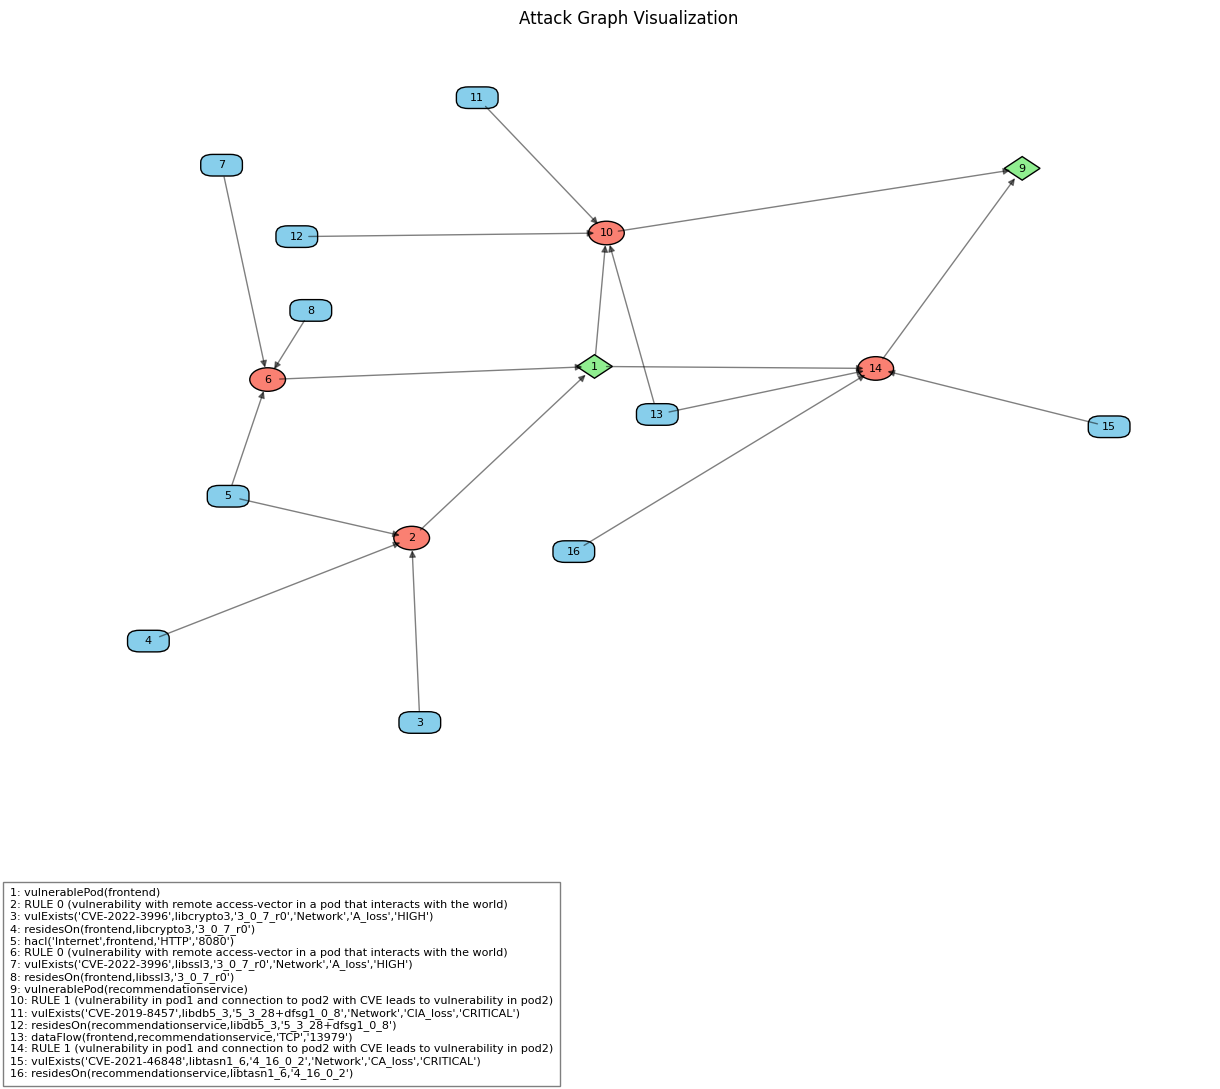

In [218]:
def read_and_prepare_data(arcs_file, vertices_file):
    # Reading the arcs file
    arcs_df = pd.read_csv(arcs_file, usecols=[0, 1], header=None)  # Select only the first two columns
    arcs_df.columns = ['End_Node', 'Start_Node']

    # Reading the vertices file
    vertices_df = pd.read_csv(vertices_file, header=None)
    
    # Using the correct headers as per the provided structure
    vertices_df.columns = ['Node_ID', 'Description', 'Type', 'Status']
    return arcs_df, vertices_df

def create_graph(arcs_df, vertices_df):
    # Creating a directed graph
    G = nx.DiGraph()

    # Adding nodes to the graph with their type and status
    for idx, row in vertices_df.iterrows():
        G.add_node(row['Node_ID'], description=row['Description'], type=row['Type'], status=row['Status'])

    # Adding edges (arcs) to the graph
    for idx, row in arcs_df.iterrows():
        G.add_edge(row['Start_Node'], row['End_Node'])

    return G


def plot_graph(G):
    # Define figure and axis with enough space for the legend below the graph
    fig, ax = plt.subplots(figsize=(15, 12))
    plt.subplots_adjust(bottom=0.25)  # Adjust the bottom to make space for the legend

    # Using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for optimal distance and iterations for layout precision

    # Scaling factors for the nodes (reduced sizes)
    node_width = 0.03  # Decrease the width for nodes
    node_height = 0.015  # Decrease the height for nodes
    diamond_size = 0.03  # Decrease the size for diamonds
    circle_radius = 0.03  # Decrease the radius for circles

    # Draw nodes with different shapes based on type
    for node, data in G.nodes(data=True):
        node_type = data['type']
        x, y = pos[node]
        if node_type == 'LEAF':
            # Draw a rectangle for LEAF nodes
            shape = mpatches.FancyBboxPatch((x - node_width/2, y - node_height/2), node_width, node_height, 
                                             boxstyle="round,pad=0.02", fc='skyblue', ec='black')
        elif node_type == 'OR':
            # Draw a diamond for OR nodes
            shape = mpatches.RegularPolygon((x, y), numVertices=4, radius=diamond_size, orientation=0, fc='lightgreen', ec='black')
        else:  # node_type == 'AND'
            # Draw a circle for AND nodes
            shape = plt.Circle((x, y), circle_radius, fc='salmon', ec='black')

        ax.add_patch(shape)

    # Drawing edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Node labels - Using Node ID
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Set title and turn off the axis
    plt.title('Attack Graph Visualization')
    ax.axis('off')  # Turn off the axis
    
    # Create a legend with descriptions, aligned to the left
    legend_labels = {node: data['description'] for node, data in G.nodes(data=True)}
    legend_text = "\n".join(f"{node_id}: {desc}" for node_id, desc in legend_labels.items())
    
    # Place the legend outside the plot area, aligned to the left
    plt.figtext(0.1, 0.01, legend_text, ha='left', fontsize=8, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    # Show the plot
    plt.show()


arcs_df, vertices_df = read_and_prepare_data(arcs_file, vertices_file)
G = create_graph(arcs_df, vertices_df)
plot_graph(G)


## Load Alert Data

In [219]:
df_alerts = pd.read_csv(alert_data_path)
df_alerts

Source Service         Target Service  Source Process ID  \
0                frontend              adservice             2646.0   
1                frontend            cartservice             2916.0   
2                frontend              adservice             2067.0   
3                frontend              adservice             1727.0   
4                frontend            cartservice             2089.0   
5   recommendationservice              adservice             2818.0   
6   recommendationservice               frontend             2806.0   
7   recommendationservice               frontend             2815.0   
8               adservice            cartservice             2376.0   
9               adservice  recommendationservice             2378.0   
10            cartservice               frontend             2507.0   
11            cartservice               frontend             3154.0   
12            cartservice  recommendationservice             3037.0   
13            cartservice               frontend             3038.0   

    Target Process ID                                         Alert Type  \
0              2375.0  Unusual Network Connections Following Privileg...   
1              2440.0       Suspicious File Access Patterns Across Hosts   
2              3127.0            Anomalous Access Across Different Hosts   
3                 NaN              Irregular Use of Administrative Tools   
4              1843.0       Suspicious File Access Patterns Across Hosts   
5              2376.0            Anomalous Access Across Different Hosts   
6              2089.0       Suspicious File Access Patterns Across Hosts   
7              3490.0                Unexpected Remote Process Execution   
8              2535.0            Anomalous Access Across Different Hosts   
9              3372.0  Unusual Network Connections Following Privileg...   
10             2919.0              Abnormal Service or Daemon Activities   
11             2305.0                Unexpected Remote Process Execution   
12             2808.0  Unusual Network Connections Following Privileg...   
13             1712.0  Unusual Network Connections Following Privileg...   

                                          Description Severity  
0   Lateral movement detected from frontend (PID: ...     High  
1   Lateral movement detected from frontend (PID: ...     High  
2   Lateral movement detected from frontend (PID: ...     High  
3   Lateral movement detected from frontend (PID: ...     High  
4   Lateral movement detected from frontend (PID: ...     High  
5   Lateral movement detected from recommendations...     High  
6   Lateral movement detected from recommendations...     High  
7   Lateral movement detected from recommendations...     High  
8   Lateral movement detected from adservice (PID:...     High  
9   Lateral movement detected from adservice (PID:...     High  
10  Lateral movement detected from cartservice (PI...     High  
11  Lateral movement detected from cartservice (PI...     High  
12  Lateral movement detected from cartservice (PI...     High  
13  Lateral movement detected from cartservice (PI...     High

## Filter Provenance Data by Alerted Services

In [220]:
def get_alerted_services(app_process, alerts):
    # Creating copies of the DataFrames to avoid SettingWithCopyWarning
    alerts_copy = alerts.copy()
    app_process_copy = app_process.copy()
    
    # Converting the relevant columns to string and removing trailing '.0'
    alerts_copy['Source Process ID'] = alerts_copy['Source Process ID'].astype(str).str.replace('.0', '', regex=False)
    alerts_copy['Target Process ID'] = alerts_copy['Target Process ID'].astype(str).str.replace('.0', '', regex=False)
    app_process_copy['pid'] = app_process_copy['pid'].astype(str).str.replace('.0', '', regex=False)
    
    # Merge the data on both Source and Target Process ID from alerts with pid from app_process
    merged_source = pd.merge(alerts_copy, app_process_copy, left_on='Source Process ID', right_on='pid')
    merged_target = pd.merge(alerts_copy, app_process_copy, left_on='Target Process ID', right_on='pid')

    # Combining the data from both merges and extracting the unique services
    all_merged = pd.concat([merged_source, merged_target])
    all_alerted_services = all_merged['svc'].unique()

    return all_alerted_services

alerted_services = get_alerted_services(app_process_df, df_alerts)
alerted_services

array(['frontend', 'recommendationservice', 'adservice', 'cartservice'],
      dtype=object)

In [221]:
def filter_by_services(app_process, artifacts, edges, services):
    # Filter processes and artifacts by services
    filtered_processes = app_process[app_process['svc'].isin(services)]
    filtered_artifacts = artifacts[artifacts['svc'].isin(services)]

    # Combine the IDs of filtered processes and artifacts to create a list of remaining node IDs
    remaining_node_ids = pd.concat([filtered_processes['id'], filtered_artifacts['id']])

    # Filter edges where both from and to nodes are in the remaining node list
    filtered_edges = edges[(edges['from'].isin(remaining_node_ids)) & 
                           (edges['to'].isin(remaining_node_ids))]

    return filtered_processes, filtered_artifacts, filtered_edges

filtered_process_df, filtered_artifact_df, filtered_edges_df=filter_by_services(app_process_df, app_artifact_df, app_edges_df, alerted_services)

number of edges: 1035
number of vertices: 1088
number of processes: 258
number of artifacts: 830


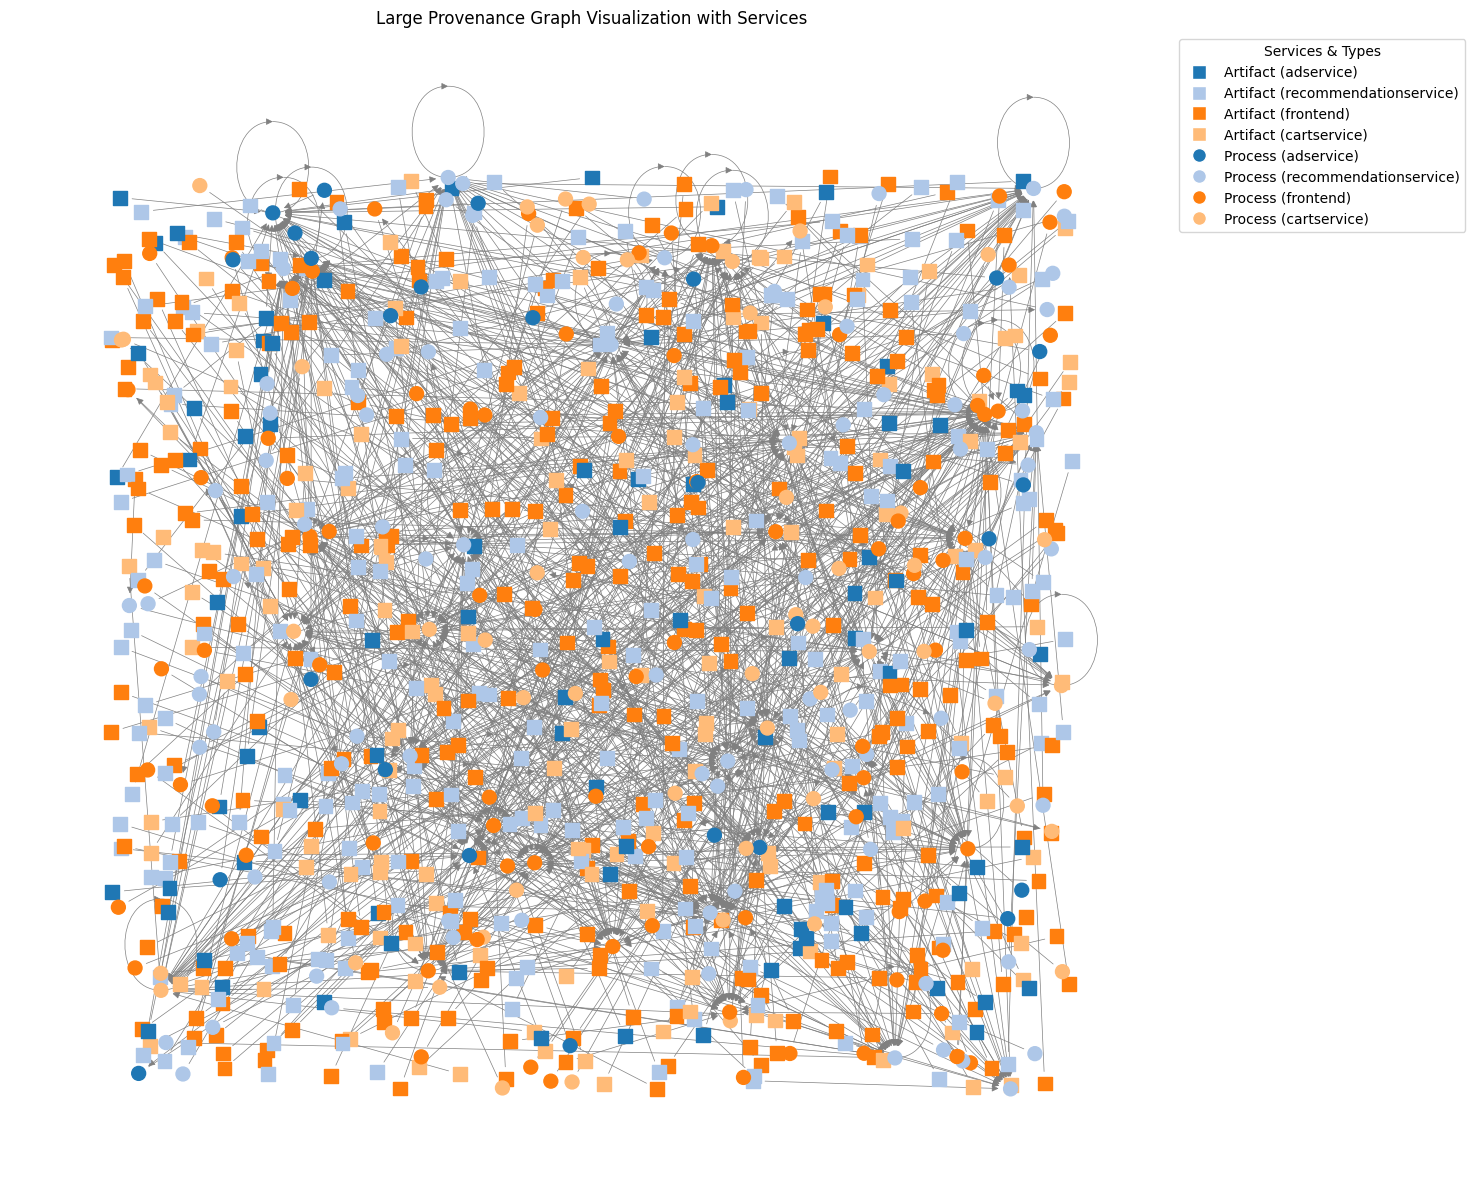

In [222]:
create_large_provenance_graph_with_services(filtered_artifact_df, filtered_process_df, filtered_edges_df)

## Filter Provenance Data by Vulnerable Pods Found in Attack Graph

In [223]:
def find_vulnerable_pods(G):
    # Regular expression pattern to match descriptions of vulnerable pods
    pattern = re.compile(r'vulnerablePod\((.*?)\)')

    # List to hold the names of vulnerable pods
    vulnerable_pods = []

    # Iterate through each node and its data in the graph
    for node, data in G.nodes(data=True):
        description = data.get('description', '')
        match = pattern.search(description)
        if match:
            # Extract the pod name from the description and add it to the list
            pod_name = match.group(1)
            vulnerable_pods.append(pod_name)

    return vulnerable_pods

vulnerable_pods = find_vulnerable_pods(G)
print("Vulnerable Pods:", vulnerable_pods)

Vulnerable Pods: ['frontend', 'recommendationservice']


number of edges: 717
number of vertices: 759
number of processes: 178
number of artifacts: 581


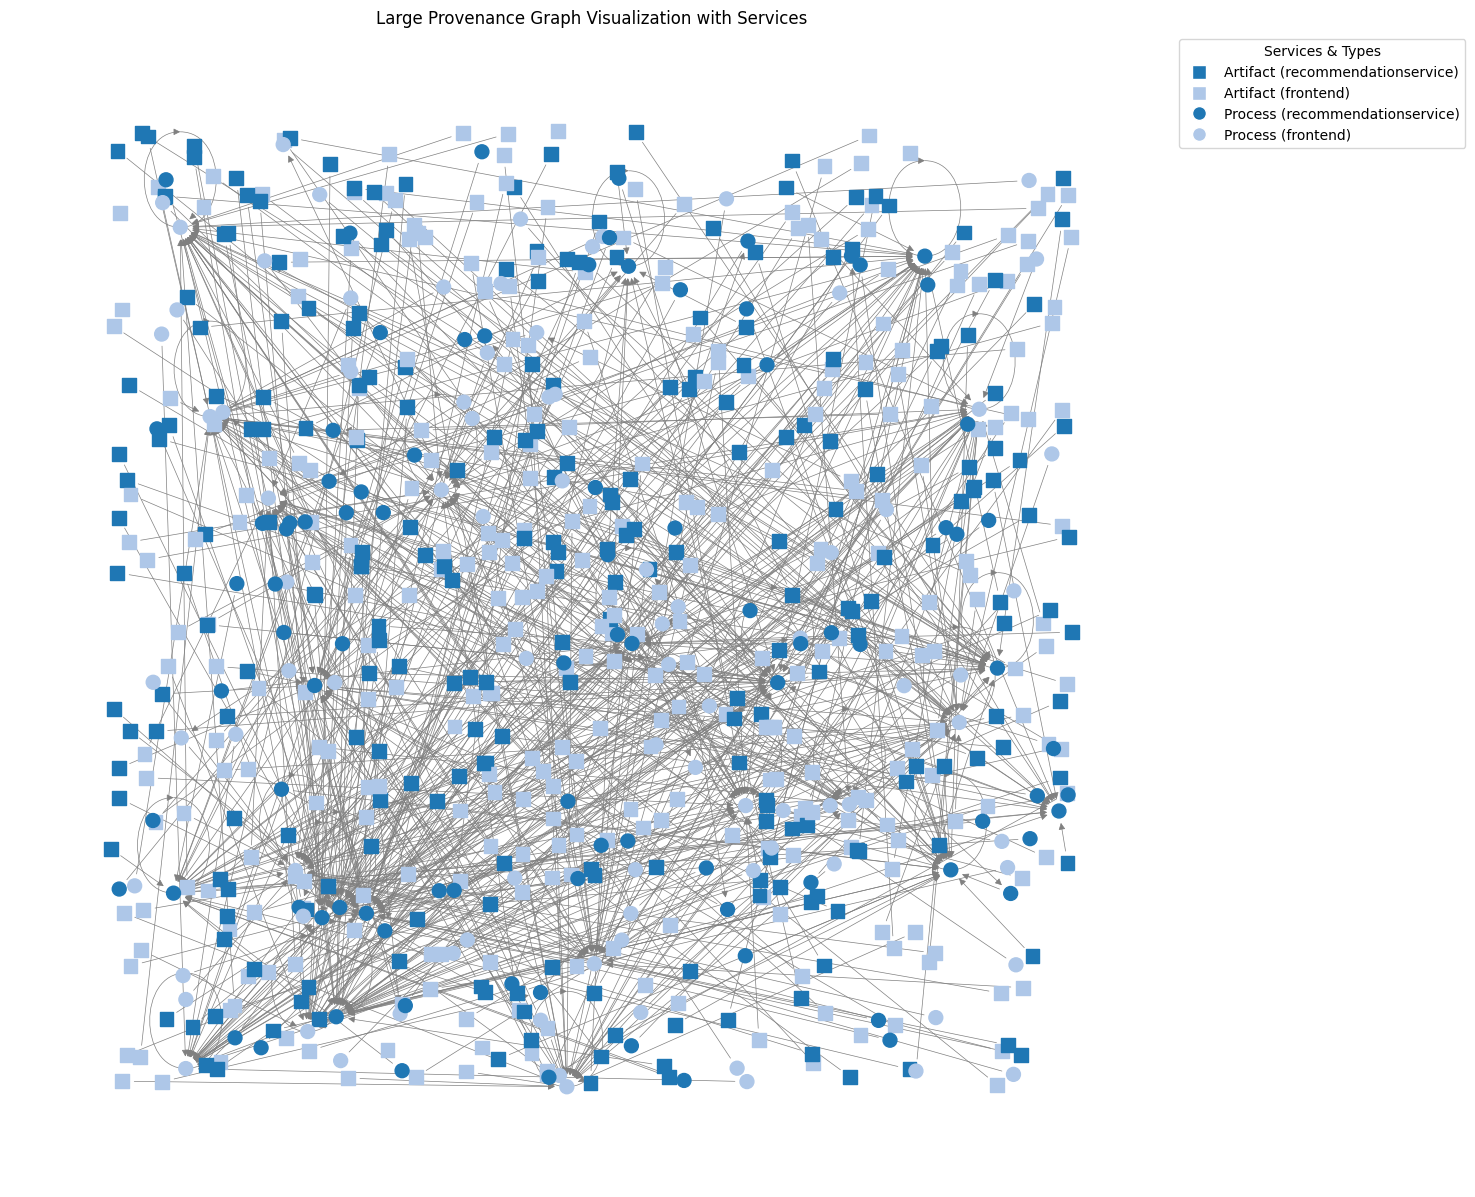

In [224]:
ag_process_df, ag_artifact_df, ag_edges_df = filter_by_services(filtered_process_df, filtered_artifact_df, filtered_edges_df, vulnerable_pods)
create_large_provenance_graph_with_services(ag_artifact_df, ag_process_df, ag_edges_df)

## Filter Provenance Data by Internet-Facing Services Found in Attack Graph

In [225]:
def find_internet_entry_paths_with_ports(G):
    # Regular expression pattern to match descriptions indicating internet access with ports
    pattern = re.compile(r"hacl\('Internet',\s*([^,]+),\s*'[^']*',\s*'(\d+)'\)")

    # List to hold the nodes accessible from the internet along with their ports
    internet_accessible_paths = []

    # Iterate through each node and its data in the graph
    for node, data in G.nodes(data=True):
        description = data.get('description', '')
        matches = pattern.findall(description)
        for match in matches:
            # Each match is a tuple with the node name and port indicating it's accessible from the internet
            internet_accessible_paths.append((match[0].strip(), match[1].strip()))

    return internet_accessible_paths

entry_paths_with_ports = find_internet_entry_paths_with_ports(G)
print("Entry paths from the Internet with ports:", entry_paths_with_ports)

Entry paths from the Internet with ports: [('frontend', '8080')]


In [226]:
def draw_graph_with_custom_labels_and_shapes_colored_edge(artifacts_df, processes_df, edges_df, name='prov_graph_custom'):
    G = nx.DiGraph()

    # Generate a color palette for services
    service_column = 'svc'
    services = list(set(artifacts_df[service_column].unique()).union(set(processes_df[service_column].unique())))
    color_map = {services[0]: 'lightblue', services[1]: 'lightgreen'}

    # Edge color mapping
    edge_colors_dict = {
        'WasGeneratedBy': 'red',
        'Used': 'green',
        'WasTriggeredBy': 'blue',
        'WasDerivedFrom': 'yellow'
    }

    # Add nodes and define labels
    labels = {}
    for _, row in artifacts_df.iterrows():
        G.add_node(row['id'], type='Artifact', svc=row[service_column])
        labels[row['id']] = int(row.get('remote port', ''))

    for _, row in processes_df.iterrows():
        G.add_node(row['id'], type='Process', svc=row[service_column])
        labels[row['id']] = int(row.get('pid', ''))

    # Add edges and store edge colors
    edge_colors = []
    for _, row in edges_df.iterrows():
        if row['from'] in G and row['to'] in G:
            G.add_edge(row['from'], row['to'])
            edge_type = row.get('type', 'default')
            edge_colors.append(edge_colors_dict.get(edge_type, 'black'))

    # Define positions
    pos = {}
    service_nodes = {svc: [n for n in G.nodes if G.nodes[n]['svc'] == svc] for svc in services}
    for svc, nodes in service_nodes.items():
        grid_size = int(np.ceil(np.sqrt(len(nodes))))
        grid_positions = [(x, y) for y in range(grid_size) for x in range(grid_size)]
        if svc == services[0]:
            grid_positions = [(x - grid_size, y) for x, y in grid_positions]  # Shift to the left
        else:
            grid_positions = [(x + 1, y) for x, y in grid_positions]          # Shift to the right
        pos.update({n: pos for n, pos in zip(nodes, grid_positions)})

    # Draw the graph
    plt.figure(figsize=(20, 10))
    for node_type, shape in [('Artifact', 's'), ('Process', 'o')]:
        nodes = [n for n, d in G.nodes(data=True) if d['type'] == node_type]
        node_colors = [color_map.get(G.nodes[n]['svc'], 'gray') for n in nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=500, node_color=node_colors, node_shape=shape)

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    plt.title("Graph with Custom Labels and Shapes")
    plt.axis('off')
    plt.savefig(f'{name}.png', bbox_inches="tight", pad_inches=1)
    plt.show()

    # Create a separate figure for the legend
    fig_legend = plt.figure(figsize=(8, 3))
    artifact_patch = plt.Line2D([0], [0], marker='s', color='w', label='Artifact', markersize=10, markerfacecolor='gray', linestyle='None')
    process_patch = plt.Line2D([0], [0], marker='o', color='w', label='Process', markersize=10, markerfacecolor='gray', linestyle='None')
    service_patches = [plt.Line2D([0], [0], marker='o', color=color_map[svc], label=svc, markersize=10, markerfacecolor=color_map[svc], linestyle='None') for svc in services]
    edge_type_patches = [plt.Line2D([0], [0], color=edge_colors_dict[edge_type], lw=2, label=edge_type) for edge_type in edge_colors_dict.keys()]
    plt.legend(handles=[artifact_patch, process_patch] + service_patches + edge_type_patches, loc='center', ncol=2)
    plt.axis('off')
    fig_legend.savefig(f'{name}_legend.png', bbox_inches="tight", pad_inches=1)
    plt.show()

Number of target artifacts for specified services and ports: 25
Total connected nodes: 70


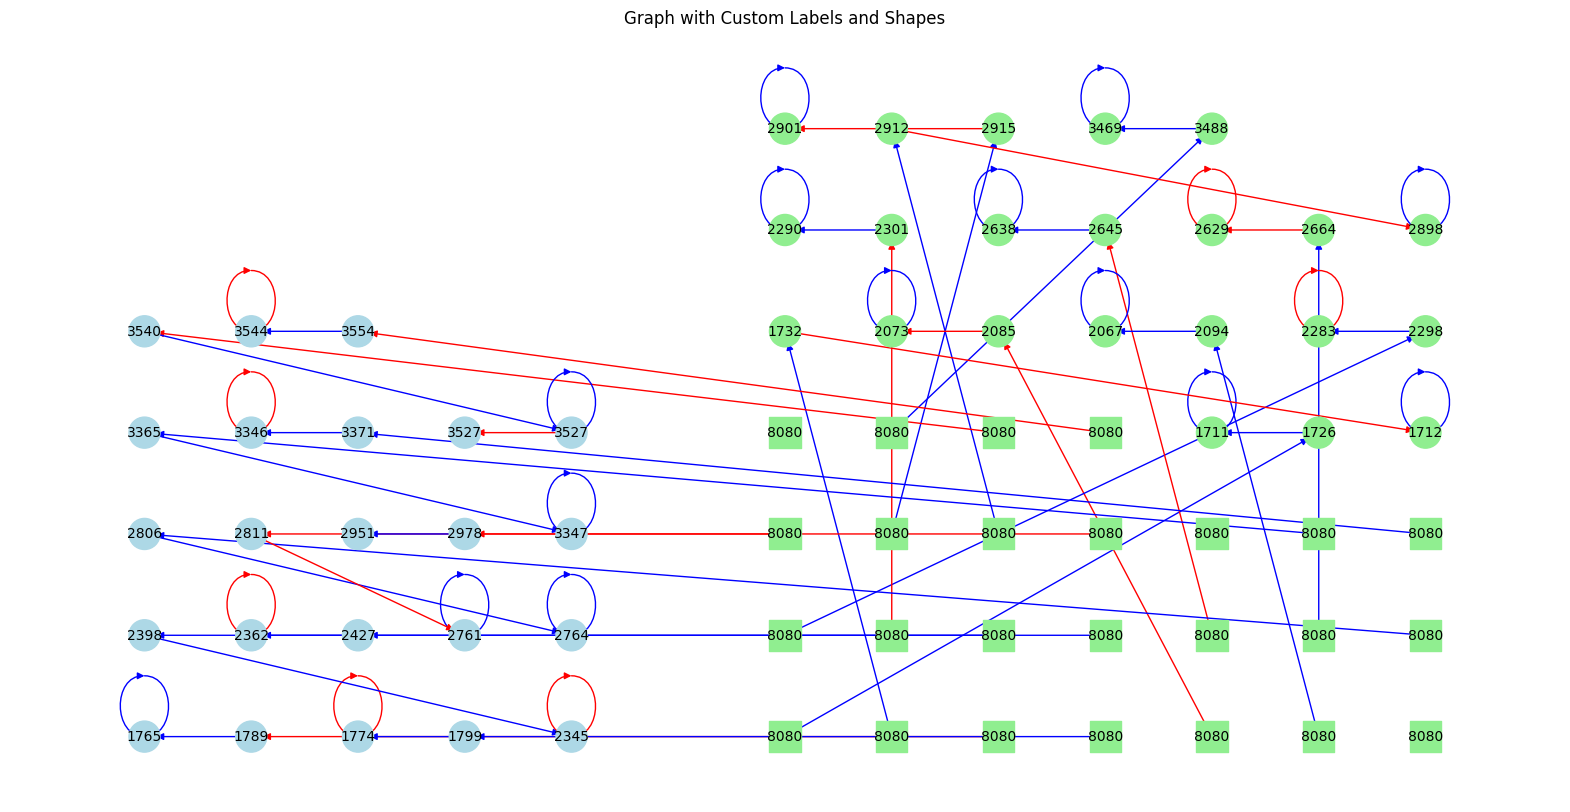

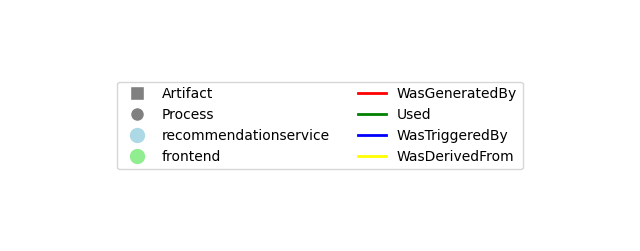

In [227]:
def filter_by_services_and_ports(artifacts_df, processes_df, edges_df, service_port_pairs):
    # Convert the port columns to numeric values, handling errors by converting them to NaN
    artifacts_df.loc[:, 'remote port'] = pd.to_numeric(artifacts_df['remote port'], errors='coerce')
    
    # Initialize a set to hold all target artifact IDs from the specified service-port pairs
    target_ids = set()

    # Iterate over each service-port pair
    for service, port in service_port_pairs:
        # Convert port to a number (float or int) for comparison
        port_num = float(port) if '.' in port else int(port)

        # Identify artifacts with the specified service and port
        target_artifacts = artifacts_df[
            ((artifacts_df['remote port'] == port_num) | (artifacts_df['local port'] == port_num)) & 
            (artifacts_df['svc'] == service)
        ]
        target_ids.update(target_artifacts['id'])

    print(f"Number of target artifacts for specified services and ports: {len(target_ids)}")

    # Create a graph
    G = nx.DiGraph()

    # Add nodes for all artifacts and processes
    for _, row in artifacts_df.iterrows():
        G.add_node(row['id'], type='Artifact', svc=row['svc'])
    for _, row in processes_df.iterrows():
        G.add_node(row['id'], type='Process', svc=row['svc'])

    # Add edges
    for _, row in edges_df.iterrows():
        G.add_edge(row['from'], row['to'])

    # Find all nodes connected to the target nodes
    connected_nodes = set()
    for node in target_ids:
        ancestors = nx.ancestors(G, node)
        descendants = nx.descendants(G, node)
        connected_nodes.update(ancestors)
        connected_nodes.update(descendants)
        connected_nodes.add(node)

    print(f"Total connected nodes: {len(connected_nodes)}")

    # Filter artifacts and processes DataFrames
    filtered_artifacts = artifacts_df[artifacts_df['id'].isin(connected_nodes)]
    filtered_processes = processes_df[processes_df['id'].isin(connected_nodes)]

    # Filter edges DataFrame
    filtered_edges = edges_df[edges_df['from'].isin(connected_nodes) | edges_df['to'].isin(connected_nodes)]

    return filtered_artifacts, filtered_processes, filtered_edges

ag_paths_artifact_df, ag_paths_process_df, ag_paths_edges_df = filter_by_services_and_ports(ag_artifact_df,ag_process_df, ag_edges_df, entry_paths_with_ports)
draw_graph_with_custom_labels_and_shapes_colored_edge(ag_paths_artifact_df, ag_paths_process_df,ag_paths_edges_df)

## Filter Provenance Data by Paths to Alerted Processes From Internet-Facing Services

C:\Users\User\AppData\Local\Temp\ipykernel_400\1300058335.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processes_df['pid'] = pd.to_numeric(processes_df['pid'], errors='coerce')


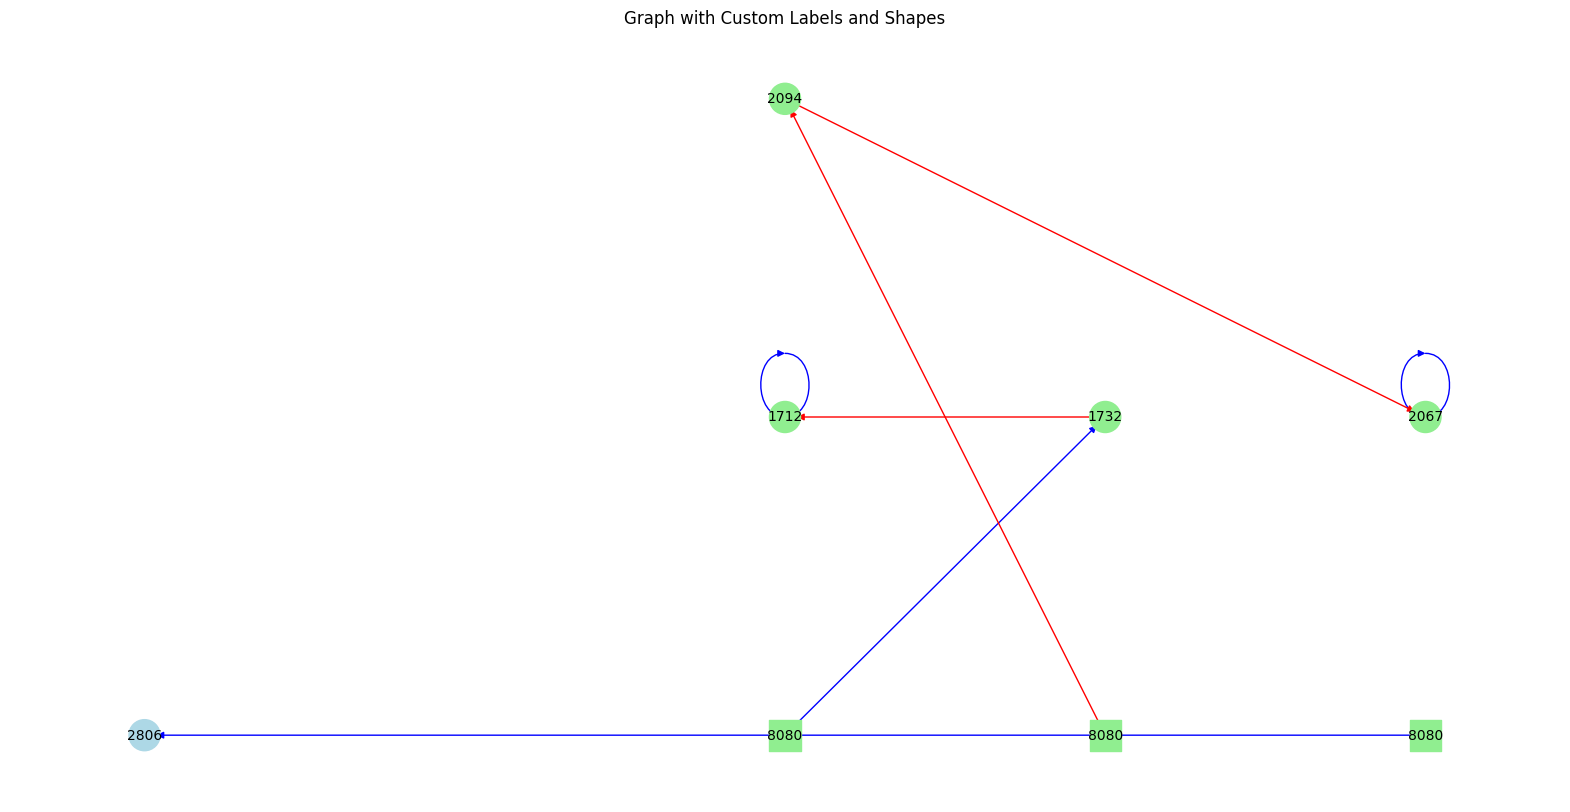

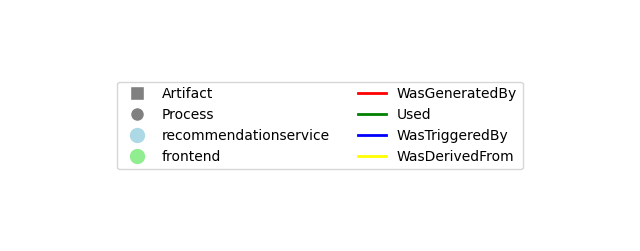

In [228]:
def filter_paths_to_alerted_processes(processes_df, artifacts_df, edges_df, alerts_data, internet_services_ports):
    # Convert alert process IDs to numeric and identify unique alerted process IDs
    alerts_data['Source Process ID'] = pd.to_numeric(alerts_data['Source Process ID'], errors='coerce')
    alerts_data['Target Process ID'] = pd.to_numeric(alerts_data['Target Process ID'], errors='coerce')
    alerted_process_ids = set(alerts_data['Source Process ID'].dropna()) \
                          .union(alerts_data['Target Process ID'].dropna())
    
    # Convert 'pid' in processes_df to numeric for matching
    processes_df['pid'] = pd.to_numeric(processes_df['pid'], errors='coerce')
    alerted_processes = processes_df[processes_df['pid'].isin(alerted_process_ids)]
    alerted_node_ids = set(alerted_processes['id'])
    
    # Create a graph
    G = nx.DiGraph()
    for _, row in artifacts_df.iterrows():
        G.add_node(row['id'], type='Artifact', svc=row['svc'])
    for _, row in processes_df.iterrows():
        G.add_node(row['id'], type='Process', svc=row['svc'])
    for _, row in edges_df.iterrows():
        G.add_edge(row['from'], row['to'])
    
    # Identify internet-facing nodes based on provided services and ports
    internet_nodes = set()
    for service, port in internet_services_ports:
        port_num = float(port) if '.' in port else int(port)
        target_artifacts = artifacts_df[
            ((artifacts_df['remote port'] == port_num) | (artifacts_df['local port'] == port_num)) & 
            (artifacts_df['svc'] == service)
        ]
        internet_nodes.update(target_artifacts['id'])
    
    # Find paths from internet nodes to alerted processes
    paths_to_alerted = set()
    for internet_node in internet_nodes:
        for alerted_node in alerted_node_ids:
            if nx.has_path(G, internet_node, alerted_node):
                paths_to_alerted.update(nx.shortest_path(G, internet_node, alerted_node))

    # Remove isolated nodes (artifacts with no connections)
    isolated_nodes = {node for node in G.nodes() if G.in_degree(node) + G.out_degree(node) == 0}
    paths_to_alerted -= isolated_nodes

    # Filter processes, artifacts, and edges based on the paths to alerted nodes
    filtered_processes = processes_df[processes_df['id'].isin(paths_to_alerted)]
    filtered_artifacts = artifacts_df[artifacts_df['id'].isin(paths_to_alerted)]
    filtered_edges = edges_df[edges_df['from'].isin(paths_to_alerted) | edges_df['to'].isin(paths_to_alerted)]
    
    return filtered_processes, filtered_artifacts, filtered_edges

alerted_processes_df,alerted_artifacts_df, alerted_edges_df = filter_paths_to_alerted_processes(ag_paths_process_df,ag_paths_artifact_df, ag_paths_edges_df , df_alerts, entry_paths_with_ports)

draw_graph_with_custom_labels_and_shapes_colored_edge(alerted_artifacts_df, alerted_processes_df, alerted_edges_df)